In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import linalg
from Mesh import Mesh

import matplotlib.pyplot as plt


In [2]:
# Convert to torch tensors (double precision for better numerical stability)
torch.set_default_dtype(torch.double)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
m = Mesh('data/coil_1.2_MM.obj')

centroid = m.verts.mean(0)
std_max = m.verts.std(0).max()

verts_new = (m.verts - centroid)/std_max

m = Mesh(verts = verts_new, connectivity = m.connectivity)

print('Computing Laplacian')
K, M = m.computeLaplacian()

# following Finite Elements methodology 
# K is stiffness matrix, M is mass matrix
# The problem to solve becomes 
# K*u = lambda * M*u
print('Computing eigen values')
eigvals, eigvecs = linalg.eigh(K,M)

Computing Laplacian
Computing eigen values


In [4]:
# send all relevant numpy arrays to torch tensors
K = torch.from_numpy(K).to(device)
M = torch.from_numpy(M).to(device)
X = torch.from_numpy(m.verts).to(device)

In [5]:
# in the paper we used 50 eigenvalues so set k to 50
k = 50

In [6]:
class MLP(nn.Module):
    """
    Multilayer Perceptron for mapping coordinates to k eigenmodes.
    Uses SiLU (Swish) activation for better gradient flow than Tanh.
    """
    def __init__(self, in_dim=3, out_dim=k, hidden=[64, 64]):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            # Using nn.SiLU (Swish) instead of nn.Tanh
            layers.append(nn.Linear(last, h))
            layers.append(nn.SiLU())
            last = h
        layers.append(nn.Linear(last, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)  # returns (N, k)

# --- 3. Model Instantiation and Initialization ---

# Instantiate model
model = MLP().to(device)

# Initialize all layers (Xavier), final layer small (Best practice for PINNs)
for name, p in model.named_parameters():
    if 'net' in name:
        # Standard Xavier for hidden layers (weights)
        if p.dim() > 1 and name.split('.')[1] != str(len(model.net) - 1):
            nn.init.xavier_uniform_(p.data)
        # Final Linear layer: Small weights and zero bias
        if name.split('.')[1] == str(len(model.net) - 1):
            if p.ndim == 2:
                # Weights: Very small normal distribution
                nn.init.normal_(p.data, std=1e-3)
            else:
                # Biases: Zero
                nn.init.zeros_(p.data)

# --- 4. Training Setup ---

# Hyperparameters
# CRITICAL FIX: Since we are using M-orthogonalization (SVD projection), 
# lambda_orth can be set very low, focusing the optimizer on eig_loss.
lambda_orth = 0.01         
lr_start = 0.01
lr_end = 0.0001
max_epochs = 100_000 # Reverting to a more manageable epoch count for testing         
print_every = 500
loss_history = []

optimizer = optim.Adam(model.parameters(), lr=lr_start)
decay_factor = (lr_end / lr_start) ** (1 / max_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_factor)

# --- 5. Training Loop ---

print("\n--- Starting Full-Batch Training with SVD Stabilization ---")
identity_k = torch.eye(k, device=device)

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward Pass (Full Batch)
    U = model(X)  # N x k (Basis functions evaluated at coordinates X)
    
    # --- CRITICAL STABILIZATION STEP: M-Orthogonalization via SVD ---
    
    # 1. Compute the inner product matrix B = U^T M U
    B = U.T @ (M @ U)        # k x k 

    # 2. Perform SVD on B: B = V @ S @ V.T (since B is symmetric)
    # This is a differentiable way to compute B^(-1/2)
    V, S, _ = torch.linalg.svd(B)
    
    # 3. Compute the inverse square root of S, clamping small values for stability
    S_inv_sqrt = torch.diag_embed(1.0 / torch.sqrt(torch.clamp(S, min=1e-8)))
    
    # 4. Compute B^(-1/2) = V @ S^(-1/2) @ V.T
    B_inv_sqrt = V @ S_inv_sqrt @ V.T

    # 5. Orthogonalized Basis: U_orth = U @ B^(-1/2)
    # This guarantees that U_orth.T @ M @ U_orth is close to Identity
    U_orth = U @ B_inv_sqrt
    
    # --- Calculate Loss Components using U_orth ---
    
    # 1. Eigenvalue Loss (Minimize Rayleigh Quotient)
    # The term U_orth.T @ (K @ U_orth) is used for the trace
    eig_loss_unnorm = torch.trace(U_orth.T @ (K @ U_orth)) 
    # Normalizing by k modes balances the loss scales for the optimizer.
    eig_loss = eig_loss_unnorm / k 
    
    # 2. Orthogonality Loss (Residual Check: should be close to zero now)
    # We still compute this for tracking, but the value should be very small.
    B_orth = U_orth.T @ (M @ U_orth)        # k x k (Orthogonality matrix)
    orth_loss = torch.norm(B_orth - identity_k, p='fro')**2

    # Total Loss (Weighted sum)
    # The constraint is almost satisfied, so loss is dominated by eig_loss
    loss = eig_loss + lambda_orth * orth_loss

    # Backpropagation and Step
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # Logging and Analysis
    loss_history.append(loss.item())

    if epoch % print_every == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            # For logging the actual eigenvalues, we use the unnormalized U_orth.T @ K @ U_orth
            full_rayleigh_matrix = U_orth.T @ (K @ U_orth)
            
            # The diagonal elements of this matrix are the approximate eigenvalues.
            # No scaling is applied here, assuming K is the unscaled discrete operator.
            approx_vals = torch.diag(full_rayleigh_matrix).cpu().numpy() 
            
            # Sort and print the approximate eigenvalues for meaningful comparison
            sorted_vals = np.sort(approx_vals)
            
            current_lr = scheduler.get_last_lr()[0]
        
        # Print the normalized eig_loss value used in the training objective
        print(
            f"Epoch {epoch:<5}, LR={current_lr:.6f}, "
            f"Total Loss={loss.item():.4f}, "
            f"Norm Eig Loss={eig_loss.item():.4f}, "
            f"Orth Loss={orth_loss.item():.4f}"
        )
        #print(f"  Approx Eigenvalues (Min k): {sorted_vals}")

print("--- Training Complete ---")


--- Starting Full-Batch Training with SVD Stabilization ---
Epoch 1    , LR=0.010000, Total Loss=1.0930, Norm Eig Loss=0.7565, Orth Loss=33.6545
Epoch 500  , LR=0.009772, Total Loss=0.8243, Norm Eig Loss=0.4443, Orth Loss=37.9939
Epoch 1000 , LR=0.009550, Total Loss=0.9264, Norm Eig Loss=0.5664, Orth Loss=35.9963
Epoch 1500 , LR=0.009333, Total Loss=0.9791, Norm Eig Loss=0.6291, Orth Loss=34.9980
Epoch 2000 , LR=0.009120, Total Loss=1.0512, Norm Eig Loss=0.7112, Orth Loss=33.9985
Epoch 2500 , LR=0.008913, Total Loss=1.4095, Norm Eig Loss=1.1197, Orth Loss=28.9807
Epoch 3000 , LR=0.008710, Total Loss=1.3795, Norm Eig Loss=1.1001, Orth Loss=27.9393
Epoch 3500 , LR=0.008511, Total Loss=2.7140, Norm Eig Loss=2.5446, Orth Loss=16.9423
Epoch 4000 , LR=0.008318, Total Loss=3.6597, Norm Eig Loss=3.5599, Orth Loss=9.9845
Epoch 4500 , LR=0.008128, Total Loss=4.9795, Norm Eig Loss=4.9596, Orth Loss=1.9903
Epoch 5000 , LR=0.007943, Total Loss=4.8851, Norm Eig Loss=4.8653, Orth Loss=1.9845
Epoch 5

In [7]:
np.set_printoptions(suppress=True, precision=6)


# Final Eigenvalue Check
model.eval()
with torch.no_grad():
    U_final = model(X)
    
    # Final M-Orthogonalization
    B_final = U_final.T @ (M @ U_final)
    V_final, S_final, _ = torch.linalg.svd(B_final)
    S_inv_sqrt_final = torch.diag_embed(1.0 / torch.sqrt(torch.clamp(S_final, min=1e-8)))
    B_inv_sqrt_final = V_final @ S_inv_sqrt_final @ V_final.T
    U_orth_final = U_final @ B_inv_sqrt_final
    
    final_rayleigh_matrix = U_orth_final.T @ (K @ U_orth_final)
    final_ortho_matrix = U_orth_final.T @ (M @ U_orth_final)

    # Final eigenvalues are the diagonal elements of the Rayleigh quotient matrix
    # Again, no scaling is needed if K is the unscaled discrete operator.
    final_eigenvalues = torch.diag(final_rayleigh_matrix).cpu().numpy()
    final_eigenvalues.sort()

    print("\n--- Final Results ---")
    print(f"Final Approximate Eigenvalues (Sorted): {np.round(final_eigenvalues[:5], 6)}")
    print("Reference eigenvalues (first k):   ", np.round(eigvals[:5], 6))
    
    # Print the Orthogonality Matrix (should be extremely close to Identity)
    print("\nFinal Orthogonality Matrix (U_orth^T M U_orth):")
    print(final_ortho_matrix.cpu().numpy().round(4))



--- Final Results ---
Final Approximate Eigenvalues (Sorted): [0.33234  2.453276 2.970791 3.17843  3.295517]
Reference eigenvalues (first k):    [0.       0.007574 0.030308 0.068146 0.121208]

Final Orthogonality Matrix (U_orth^T M U_orth):
[[ 1.      0.     -0.0001 ...  0.     -0.      0.0001]
 [ 0.      1.     -0.     ... -0.     -0.      0.    ]
 [-0.0001 -0.      1.     ... -0.      0.     -0.0001]
 ...
 [ 0.     -0.     -0.     ...  1.      0.      0.    ]
 [-0.     -0.      0.     ...  0.      1.     -0.    ]
 [ 0.0001  0.     -0.0001 ...  0.     -0.      1.0002]]


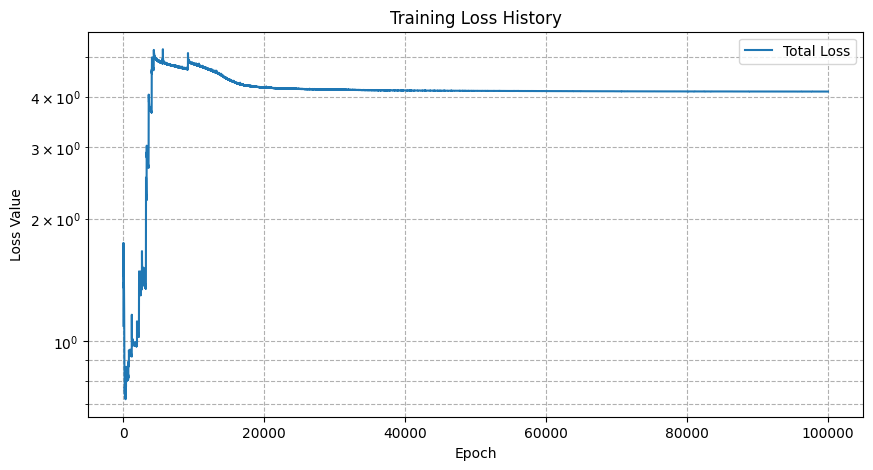

In [8]:
# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Total Loss')
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

In [ ]:
final_rayleigh_matrix